In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

In [4]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 300kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.96MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.1MB/s]


In [5]:
test_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [6]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False
)

In [7]:
len(train_set)

60000

In [8]:
print(f"Image shape: {train_set[0][0].shape}")

Image shape: torch.Size([1, 28, 28])


In [9]:
print(f"Label of first image: {train_set[0][1]}")

Label of first image: 9


In [10]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [11]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Pooling layer (ADD THIS IF MISSING)
        self.pool = nn.MaxPool2d(2, 2)  # Kernel size=2, stride=2
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))  # Correct usage
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model=FashionCNN()

In [12]:
import torch.optim as optim
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [14]:
num_epochs = 10
train_losses = []
val_accuracies = []
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    val_accuracies.append(epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Loss: {epoch_loss:.4f} | "
          f"Validation Accuracy: {epoch_acc:.2f}%")

Epoch 1/10 | Loss: 0.4454 | Validation Accuracy: 87.89%
Epoch 2/10 | Loss: 0.2882 | Validation Accuracy: 89.98%
Epoch 3/10 | Loss: 0.2378 | Validation Accuracy: 89.82%
Epoch 4/10 | Loss: 0.2068 | Validation Accuracy: 91.26%
Epoch 5/10 | Loss: 0.1770 | Validation Accuracy: 90.41%
Epoch 6/10 | Loss: 0.1571 | Validation Accuracy: 91.55%
Epoch 7/10 | Loss: 0.1348 | Validation Accuracy: 91.88%
Epoch 8/10 | Loss: 0.1155 | Validation Accuracy: 91.29%
Epoch 9/10 | Loss: 0.0986 | Validation Accuracy: 91.94%
Epoch 10/10 | Loss: 0.0838 | Validation Accuracy: 91.14%


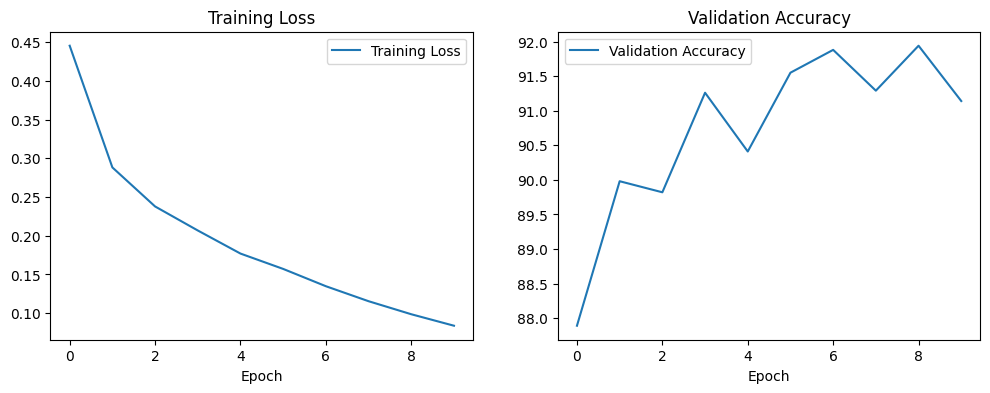

In [15]:
def plot_results():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_results()

In [16]:
def imshow(img):
    img = img * 0.5 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

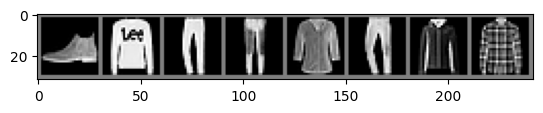

In [19]:
# Gets some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images[:8], labels[:8]

# it Show images and predictions
imshow(torchvision.utils.make_grid(images.cpu()))
outputs = model(images.to(device))
# Get both the max values and the predicted indices
_, predicted = torch.max(outputs, 1) # predicted now holds the indices

In [20]:
print('GroundTruth:', ' '.join(f'{classes[labels[j]]:15s}' for j in range(8)))
# Access the predicted indices using the modified 'predicted' variable
print('Predicted:  ', ' '.join(f'{classes[predicted[j]]:15s}' for j in range(8)))

GroundTruth: Ankle boot      Pullover        Trouser         Trouser         Shirt           Trouser         Coat            Shirt          
Predicted:   Ankle boot      Pullover        Trouser         Trouser         Shirt           Trouser         Coat            Shirt          


In [21]:
model.eval()
correct = 0
total = 0
confusion_matrix = np.zeros((10, 10), dtype=int)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

print(f'\nFinal Test Accuracy: {100 * correct / total:.2f}%')


Final Test Accuracy: 91.14%


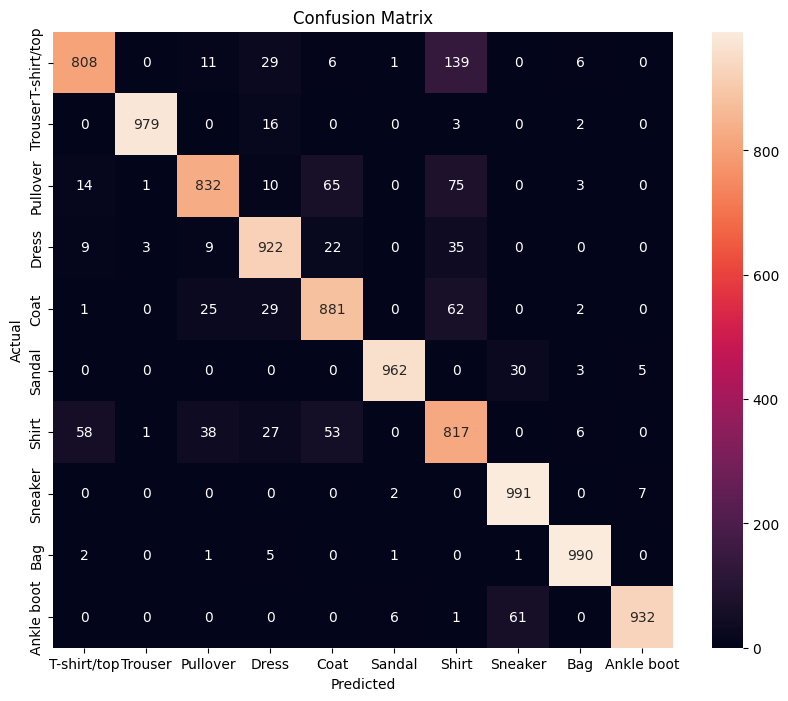

In [22]:
import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
